# 2D Seismic Refraction Modeling and Inversion with PyGIMLi

This notebook demonstrates how to perform field data inversion for a 2D seismic refraction survey using `pyGIMLi`. The data are ...

**Author:** Alberto Carrera

In [1]:
# Import the packages needed to realize the inversion modelling
import pygimli as pg
from pygimli.physics import TravelTimeManager
import matplotlib.pyplot as plt
import numpy as np
import pygimli.meshtools as mt

datadir = '../data/'
figdir = '../figures/'

fname = 'collio1'

## 1. load dataset
rstData = pg.DataContainer(datadir + fname + ".sgt", "s g")

mgr = TravelTimeManager()

# Define the error in the seismic dataset in sec (e.g. 0.003 means 3 msec)
rstData.set("err", pg.Vector(rstData.size(), 0.002))

#rstData.remove(rstData["g"] == rstData["s"]) # Remove the shoots in the same position of the geophones
rstData.remove(rstData["t"] <= 0)
rstData.remove(rstData["t"] > 1)
print(rstData)
#rstData.save('../data/fname.dat')

Data: Sensors: 26 data: 170, nonzero entries: ['err', 'g', 's', 't', 'valid']


Let’s have a look at the data in the form of traveltime curves.  
Alternatively, one can plot a matrix plot of apparent velocities which is the more general function also making sense for crosshole data.

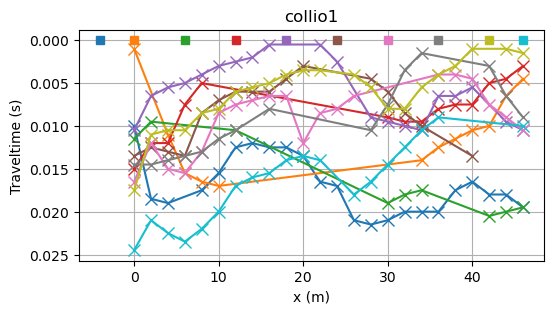

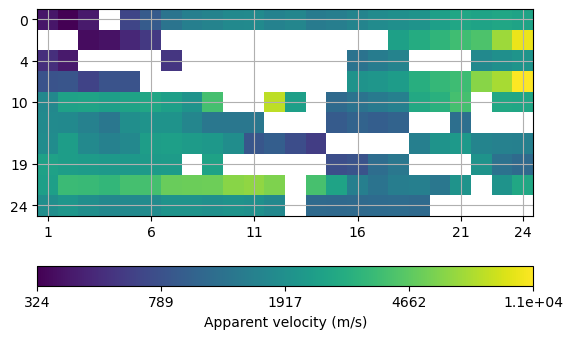

In [2]:
# see traveltime curves  
fig, ax = pg.plt.subplots(figsize=(6,3))
pg.physics.traveltime.drawFirstPicks(ax, rstData)
plt.title(fname)
#fig.savefig(figdir+ fname+'_f.png', dpi=200)

# velocity matrix
mgr = TravelTimeManager()
ax, cbar = mgr.showData(rstData)

We can now create a refined mesh based on our survey

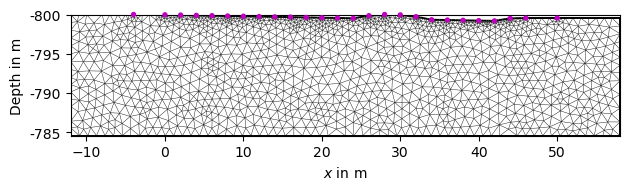

In [3]:
## 2. create mesh
sensors = np.loadtxt(datadir + "geophones_l1.txt")
plc = mt.createParaMeshPLC(sensors, paraDX=.05, boundary=2,
                               paraDepth=15,
                           paraBoundary=2, paraMaxCellSize=1.
                          )

mesh = mt.createMesh(plc, quality=33, smooth=True)
#mesh.save("mesh_1.bms")
paraDomain = pg.Mesh(2)
paraDomain.createMeshByMarker(mesh, 2)
paraDomain.save("paraDomain_1.bms")
# plot
am, _ = pg.show(paraDomain, alpha=0.3, hold=True, colorBar=False)
pg.viewer.mpl.drawSensors(am, sensors, diam=0.5,
                         facecolor='m', edgecolor='m')

Finally, we call the invert method and plot the result.The mesh is created based on the sensor positions on-the-fly.

In [4]:
## 3. inversion
vMesh = pg.load("paraDomain_1.bms")
mgr.setMesh(vMesh)
inverted = mgr.invert(rstData, mesh=vMesh, 
                      lam=30, #zWeight=0.5,
                      vTop=100, vBottom=6000, verbose=True)

07/10/25 - 16:26:15 - pyGIMLi - INFO - Found 1 regions.
07/10/25 - 16:26:15 - pyGIMLi - INFO - Found 1 regions.
07/10/25 - 16:26:15 - pyGIMLi - INFO - Creating forward mesh from region infos.
07/10/25 - 16:26:15 - pyGIMLi - INFO - Creating refined mesh (secnodes: 2) to solve forward task.
07/10/25 - 16:26:15 - pyGIMLi - INFO - Create gradient starting model. 100: 6000
07/10/25 - 16:26:15 - pyGIMLi - INFO - Created startmodel from forward operator:2685, min/max=0.000167/0.010000
07/10/25 - 16:26:15 - pyGIMLi - INFO - Starting inversion.


min/max(dweight) = 500/500
fop: <pygimli.physics.traveltime.modelling.TravelTimeDijkstraModelling object at 0x70e0655cfbf0>
Data transformation: Identity transform
Model transformation: Logarithmic transform
min/max (data): 5.0e-04/0.02
min/max (error): 8.16%/400%
min/max (start model): 1.7e-04/0.01
--------------------------------------------------------------------------------
min/max(dweight) = 500/500
Building constraints matrix
constraint matrix of size(nBounds x nModel) 3885 x 2685
check Jacobian: wrong dimensions: (0x0) should be (170x2685)  force: 1
jacobian size invalid, forced recalc: 1
inv.iter 0 ... chi² =   34.56
--------------------------------------------------------------------------------
inv.iter 1 ... Calculating Jacobian matrix (forced=1)...... 0.75127 s
min data = 0.0005 max data = 0.0245 (170)
min error = 0.0816327 max error = 4 (170)
min response = 0 max response = 0.0281328 (170)
calc without reference model
0: rms/rrms(data, response) = 0.0117577/359.035%
0: ch

Look at the fit between measured (crosses) and modelled (lines) traveltimes.

RST chi: 2.752971440322052
RST rms: 56.640275124468644


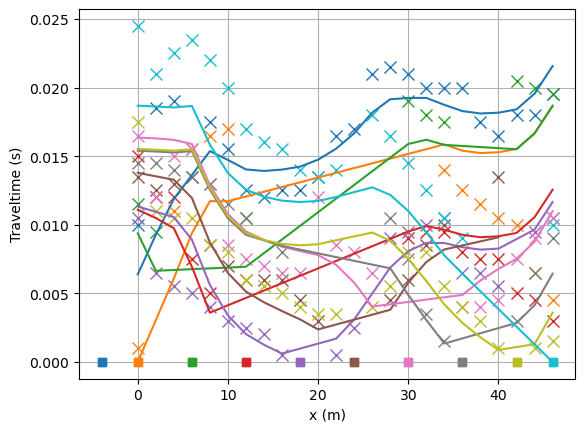

In [5]:
mgr.showFit(firstPicks=True)
print("RST chi:", mgr.inv.chi2())
print("RST rms:", mgr.inv.relrms())

Text(0.5, 1.0, 'collio1:  $\\chi^2$=2.8, rrmse=56.6')

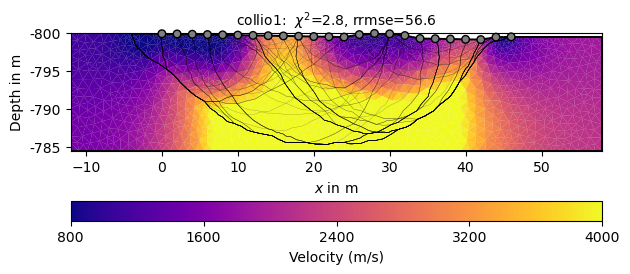

In [6]:
# plot model
ax, cbar = mgr.showResult(logScale=False, cMin=800, cMax=4000, cMap="plasma")
rays = mgr.drawRayPaths(ax=ax, color="k", lw=0.3, alpha=0.3)
pg.viewer.mpl.drawSensors(ax, sensors[1:-1], diam=1,
                         facecolor='gray', edgecolor='k')
ax.set_title(fname+ f':  $\chi^2$={mgr.inv.chi2():.1f}, '+f'rrmse={mgr.inv.relrms():.1f}', fontsize=10)

We can plot only the model and customize with a bunch of keywords

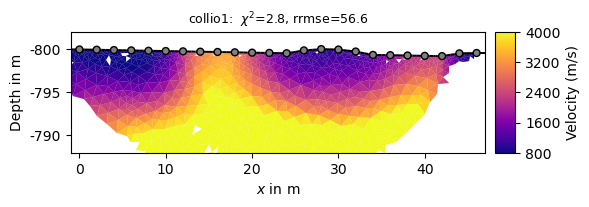

In [8]:
figdir = '../figures/'

# Vp section

vmin, vmax = 800, 4000
#plot
plt.rcParams['figure.figsize'] = [6, 2]
vp , cbar = mgr.showResult(sens=True, orientation='vertical',
                           logScale = False,
                           coverage=mgr.standardizedCoverage(), # mgr.coverage() yields the ray coverage in m and standardizedCoverage as 0/1
                           cMap='plasma',cMin=vmin,cMax=vmax,
                          )
#rays = mgr.drawRayPaths(ax=vp, color="w", lw=0.01, alpha=0.5)
pg.viewer.mpl.drawSensors(vp, sensors[1:-1], diam=.8, coords=[0, 1],
                         facecolor='gray', edgecolor='black')

vp.set_xlim(-1, 23*2+1)
vp.set_ylim(788, 802)
vp.set_title(fname+ f':  $\chi^2$={mgr.inv.chi2():.1f}, '+f'rrmse={mgr.inv.relrms():.1f}', fontsize=9)
plt.savefig(figdir + fname+'_srt.png', dpi=150)

now we can save and export the inversion results

In [9]:
import os

# Define output directory
invdir = datadir+ 'inv/'

# Check if the directory exists, and create it if it doesn't
if not os.path.exists(invdir):
    os.makedirs(invdir)
    print(f"Directory {invdir} created.")

mgr.saveResult(folder=invdir, size=(5, 1.5))

Path ../data/inv/TravelTimeManager already exists. Skipping


'../data/inv/TravelTimeManager'

In [11]:
result = mgr.paraDomain
result.addData("Vel", mgr.velocity) # add velocity
result.addData("Cov", mgr.standardizedCoverage()) # add coverage

result.exportMidCellValue(invdir+ 'model-'+ fname+ '.dat', result.data('Vel'), result.data('Cov')) # export the array
result.data

<bound method data of Mesh: Nodes: 1486 Cells: 2685 Boundaries: 285
Mesh contains data: Cov, Vel>

In [12]:
import pandas as pd          

# Caricamento
model = pd.read_csv(invdir + 'model-' + fname + '.dat', sep='\t')
model.columns = ["X", "Y", "Vel", "Cov", " "]
model.to_csv(invdir + 'model-' + fname + '.csv', sep=',')
model

,X,Y,Vel,Cov,
0,13.93730,799.636,2903.28,1,NaN
1,13.98940,799.590,2933.80,1,NaN
2,26.06730,799.793,1048.40,1,NaN
3,38.06050,799.210,2127.19,1,NaN
4,23.56090,799.444,1315.93,1,NaN
...,...,...,...,...,...
2679,8.35582,786.018,4580.65,0,NaN
2680,52.67760,792.250,2063.36,0,NaN
2681,53.71860,791.633,2088.72,0,NaN
2682,-4.04875,786.191,1807.26,0,NaN


You can play around with the gradient starting model (vTop and vBottom arguments) and the regularization strength lam and customize the mesh.